# Swish or Brick: How do NBA Player's habits affect their shot outcome?

## Introduction

<img src="https://github.com/JohnKang0720/nba-shooting-da/blob/main/images/Stephen_Curry_(33140701266).jpg?raw=true" width=500><img src="https://github.com/JohnKang0720/nba-shooting-da/blob/main/images/img2.jpg?raw=true" width=545>



In Basketball, shooting is arguably the most important part of the game as it decides the win & loss. With a great passion towards Basketball, the following question sparked my curiosity: "What characteristics of the shot of NBA players make or break the shot?". To answer this question, the metrics like shooting arc to intricate details like release point of the shot needs to be explored. As a result, this allows Statisticians and Basketball players to distinguish beneficial, as well as harmful shooting habits through such analysis. I greatly hope that similar reports help enhance the performances of players to spread the artistic component of Basketball. As a basketball lover and plyer, this report may help readers gain sense of what really makes or breaks your shot. 

In this project, machine learning models and hyperparameters were explored to choose the best model that can predict the outcome of the shot based on certain attributes. 
The dataset we use to train our models consists of 2 files where one file is the player shooting statsitics for an OPEN shot with the other one being DEFENDED. We all know NBA players make most or all their open shots, however if it's contested, the shot may not be so accurate. Hence, we want to look at what really makes a shot that goes in different from a shot that doesn't? How can we fix the form and habits to improve the shot?

The collected data contains many detailed attributes -- the features -- along with the outcome of the shot -- the target (0 or 1). We specifically look at the binary classification models such as Logistic Regression, Support Vector Classifier, K-Nearest-Neighbors, and RandomForestClassifier with each holding their own pros & cons. We can then make a visualize our predictions to see which attributes are different between a swish and a brick. 

### Dataset
The following dataset is a detailed collection of intersting metrics of the player's shots. The player-shooting files contain information about the player's shooting motion itself which are divided into made and missed shots. 
The following attributes are included:

- pid: Distinct player id
- fnm: First name
- lnm: Last name
- n: Shot taken
- bx: X-coordinate of the hand in player's perspective (beginning of shot motion)
- by: Y-coordinate of the hand in player's perspective (beginning of shot motion)
- bz: Z-coordinate of the hand in player's perspective (beginning of shot motion)
- rt: Release time
- rx: X-coordinate of the release point
- ry: Y-coordinate of the release point
- rz: Z-coordinate of the release point
- at1t - time (in seconds) when the ball first switches direction from going away from the hoop to towards the hoop. This typically happens as the player has brought the ball back above their head and starts the process of launching the ball towards the basket.
- at1x, at1y, at1z - x, y, and z coordinates at the point when the ball first switches direction from going away from the hoop to towards the hoop.
- lr1t: Time when ball shifts from left to right
- rl1t: Time when ball shifts right to left
- plr: Relative arc

## Table of Contents
1. Data Preparation & EDA
2. Data Preprocessing
3. Feature Selection / Dimensionality Reduction
4. Hyperparameter Search & Cross-Validation
5. Best Model & Prediction 
6. Visualization
7. Conclusion

## 1. Data Preparation

Objectives:
- Import necessary libraries for EDA
- Read CSV files
- Check table information
- Create new features & engineer features to explore new insights
- Visualize basic information

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [64]:
# Read all necessary files
made_shots = pd.read_csv("./data/player_metrics_open.csv")
missed_shots = pd.read_csv("./data/player_metrics_defended.csv")
position_info = pd.read_csv("./data/additional_info.csv")

In [65]:
# Get player positions from position_info

position_info = position_info[["name", "position", "shoots", "college", "career_FG%", "career_FG3%"]]

### 1.1 Made & Missed Shots Table Summary

In [66]:
made_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pid     189 non-null    int64  
 1   fnm     189 non-null    object 
 2   lnm     189 non-null    object 
 3   hght    173 non-null    float64
 4   n       189 non-null    int64  
 5   bx      188 non-null    float64
 6   by      188 non-null    float64
 7   bz      188 non-null    float64
 8   rt      188 non-null    float64
 9   rx      188 non-null    float64
 10  ry      188 non-null    float64
 11  rz      188 non-null    float64
 12  rv      188 non-null    float64
 13  rvx     188 non-null    float64
 14  rvy     188 non-null    float64
 15  rvz     188 non-null    float64
 16  mnv     188 non-null    float64
 17  mnvt    180 non-null    float64
 18  mnvx    180 non-null    float64
 19  mnvy    180 non-null    float64
 20  mnvz    180 non-null    float64
 21  mxv     188 non-null    float64
 22  mx

In [67]:
missed_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pid     189 non-null    int64  
 1   fnm     189 non-null    object 
 2   lnm     189 non-null    object 
 3   hght    173 non-null    float64
 4   n       189 non-null    int64  
 5   bx      177 non-null    float64
 6   by      177 non-null    float64
 7   bz      177 non-null    float64
 8   rt      177 non-null    float64
 9   rx      177 non-null    float64
 10  ry      177 non-null    float64
 11  rz      177 non-null    float64
 12  rv      177 non-null    float64
 13  rvx     177 non-null    float64
 14  rvy     177 non-null    float64
 15  rvz     177 non-null    float64
 16  mnv     177 non-null    float64
 17  mnvt    168 non-null    float64
 18  mnvx    168 non-null    float64
 19  mnvy    168 non-null    float64
 20  mnvz    168 non-null    float64
 21  mxv     177 non-null    float64
 22  mx

There generally seems to be around 5 to 10 missing values which will have to be removed in the preprocessing step.

### 1.2 Adding new columns

- Added a target column -- "status" -- to indicate shot outcome
- Converted height from inches to feet
- Added a "name" column to easily join tables
- Selected interesting features  

In [68]:
made_shots["status"] = 1
missed_shots["status"] = 0

In [69]:
CONV_FACTOR = 0.0833333
made_shots["hght"] = made_shots["hght"] * CONV_FACTOR
missed_shots["hght"] = missed_shots["hght"] * CONV_FACTOR

In [70]:
made_shots["name"] = made_shots["fnm"] + " " + made_shots["lnm"]
made_shots = made_shots.drop(columns=["fnm", "lnm"])

missed_shots["name"] = missed_shots["fnm"] + " " + missed_shots["lnm"]
missed_shots = missed_shots.drop(columns=["fnm", "lnm"])

In [71]:
all_p = pd.concat([made_shots, missed_shots], axis=0).drop_duplicates()
selected = [
    "name",
    "hght",
    "bx",
    "by",
    "bz",
    "rt",
    "rx",
    "ry",
    "rz",
    "rv",
    "rvx",
    "rvy",
    "rvz",
    "at1t",
    "at1x",
    "at1y",
    "at1z",
    "spl",
    "pl",
    "plr",
    "status",
]
all_p = all_p[selected]
all_p.head()

,name,hght,bx,by,bz,rt,rx,ry,rz,rv,...,rvy,rvz,at1t,at1x,at1y,at1z,spl,pl,plr,status
0,James Harden,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,...,-0.470512,12.519338,0.284,0.340173,0.074602,7.174992,4.830083,5.186692,1.073831,1
1,Damian Lillard,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,...,-0.053912,12.929490,0.292,0.276692,0.035454,6.794141,4.742339,5.123032,1.080275,1
2,Trevor Ariza,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,...,0.330577,13.284614,0.320,0.289360,0.053704,7.013671,5.382425,5.758962,1.069957,1
3,Wesley Matthews,6.333331,-0.664736,0.263333,3.188989,0.377,0.011191,-0.011425,7.446044,14.620723,...,0.108494,13.039727,0.307,0.240066,0.008181,6.707196,4.319130,4.825181,1.117165,1
4,Kyle Lowry,5.999998,-0.016750,0.262180,2.863618,0.395,0.005382,0.015878,7.853279,13.419374,...,0.298627,10.563779,0.283,0.458499,0.059336,6.879859,4.995785,5.500147,1.100958,1


*Convert the label into category to ensure data validity.*

In [ ]:
all_p["status"] = all_p["status"].astype("category")

Afterwards, the player shot metrics and the position information was joined together. Then, only the "Guard" positions were selected. The main reason is that other positions such as Power Forwards and Centers do not shoot from far away, and so they have much less variance in their made and missed shots. Hence, it will later be problematic when running classifcation due to the lack of variance allowing misclassification.

In [72]:
# Retrieve positions and filter shooters only.
all_p = pd.merge(all_p, position_info, on="name", how="left")

In [73]:
all_p = all_p[
    all_p["position"].apply(lambda x: True if (str(x).find("Guard") != -1) else False)
]
all_p.head()

,name,hght,bx,by,bz,rt,rx,ry,rz,rv,...,at1z,spl,pl,plr,status,position,shoots,college,career_FG%,career_FG3%
0,James Harden,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,...,7.174992,4.830083,5.186692,1.073831,1,Shooting Guard and Point Guard,Left,Arizona State University,44.3,36.5
1,Damian Lillard,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,...,6.794141,4.742339,5.123032,1.080275,1,Point Guard,Right,Weber State University,43.4,36.8
2,Trevor Ariza,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,...,7.013671,5.382425,5.758962,1.069957,1,Small Forward and Shooting Guard,Right,"University of California, Los Angeles",42.2,35.1
3,Wesley Matthews,6.333331,-0.664736,0.263333,3.188989,0.377,0.011191,-0.011425,7.446044,14.620723,...,6.707196,4.319130,4.825181,1.117165,1,Small Forward and Shooting Guard,Right,Marquette University,42.5,38.2
4,Kyle Lowry,5.999998,-0.016750,0.262180,2.863618,0.395,0.005382,0.015878,7.853279,13.419374,...,6.879859,4.995785,5.500147,1.100958,1,Point Guard,Right,Villanova University,42.4,36.7


*Renamed complex columns for easier reference.*

In [74]:
all_p.rename(columns={"career_FG%": "fg", "career_FG3%": "3fg"}, inplace=True)

In [75]:
all_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 380
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      268 non-null    object  
 1   hght      252 non-null    float64 
 2   bx        261 non-null    float64 
 3   by        261 non-null    float64 
 4   bz        261 non-null    float64 
 5   rt        261 non-null    float64 
 6   rx        261 non-null    float64 
 7   ry        261 non-null    float64 
 8   rz        261 non-null    float64 
 9   rv        261 non-null    float64 
 10  rvx       261 non-null    float64 
 11  rvy       261 non-null    float64 
 12  rvz       261 non-null    float64 
 13  at1t      253 non-null    float64 
 14  at1x      253 non-null    float64 
 15  at1y      253 non-null    float64 
 16  at1z      253 non-null    float64 
 17  spl       261 non-null    float64 
 18  pl        268 non-null    float64 
 19  plr       261 non-null    float64 
 20  status    268 n

*Collected rows that had "height" as null. These rows are still usable for ML processes, so we will just forward fill NA values after ordering them by "position" for now, as that is the closest similarity.*

In [76]:
all_p.loc[all_p["hght"].isnull()]

,name,hght,bx,by,bz,rt,rx,ry,rz,rv,...,at1z,spl,pl,plr,status,position,shoots,college,fg,3fg
45,Greivis Vasquez,NaN,0.064865,0.335588,3.633576,0.375,-0.005459,-0.038964,7.327755,15.641730,...,6.506331,3.713784,4.154769,1.118743,1,Point Guard and Shooting Guard,Right,University of Maryland,41.8,34.9
56,Nick Young,NaN,-0.671245,-0.217355,2.948008,0.386,-0.007268,-0.005899,8.382896,13.932958,...,7.421471,5.479378,6.029941,1.100479,1,Shooting Guard,Right,University of Southern California,41.8,37.6
66,Hollis Thompson,NaN,-0.248983,-0.077693,3.663960,0.397,0.025751,-0.051538,8.694353,14.159775,...,7.466583,5.037958,5.484327,1.088601,1,Small Forward and Shooting Guard,Right,Georgetown University,41.3,38.6
90,Marcus Thornton,NaN,-0.490227,0.464378,3.322907,0.401,-0.051060,0.041276,8.352544,12.895140,...,7.493445,5.066471,5.490294,1.083653,1,Shooting Guard,Right,Louisiana State University,42.5,35.8
95,Isaiah Canaan,NaN,-0.346530,0.290114,2.759948,0.390,0.013014,-0.045407,8.082558,13.884913,...,7.182787,5.345280,5.777668,1.080892,1,Shooting Guard and Point Guard,Right,Murray State University,37.1,35.1
121,Gary Neal,NaN,0.591223,0.268242,2.877378,0.403,-0.023078,-0.014739,8.513194,14.035985,...,7.017628,5.676254,5.971390,1.051995,1,Shooting Guard,Right,"La Salle University, Towson University",42.2,38.2
140,Tyreke Evans,NaN,-1.108165,0.519774,3.248295,0.399,-0.006470,-0.014735,7.987723,12.848535,...,7.299036,4.895060,5.363765,1.095751,1,Small Forward and Shooting Guard and Point Guard,Right,University of Memphis,44.0,32.3
171,Rasual Butler,NaN,-0.108970,-0.226178,3.349311,0.451,-0.029130,-0.071712,8.798928,10.978312,...,7.659748,5.452390,5.808511,1.065315,1,Shooting Guard and Small Forward,Right,La Salle University,40.3,36.2
236,Greivis Vasquez,NaN,-0.305476,1.432660,4.727747,0.521,0.017172,-0.057664,7.347183,12.075413,...,4.595230,3.030942,4.994854,1.647954,0,Point Guard and Shooting Guard,Right,University of Maryland,41.8,34.9
247,Nick Young,NaN,-0.648747,-0.100076,2.864599,0.411,-0.018336,-0.032349,8.624993,15.637698,...,7.658022,5.795183,6.317609,1.090148,0,Shooting Guard,Right,University of Southern California,41.8,37.6


In [77]:
all_p.loc[all_p["hght"].isnull()].index

Index([45, 56, 66, 90, 95, 121, 140, 171, 236, 247, 257, 281, 286, 312, 331,
       362],
      dtype='int64')

*Fill NA values to avoid errors.*

In [299]:
all_p.fillna(method="ffill" ,inplace=True)

C:\Users\kangj\AppData\Local\Temp\ipykernel_24788\53093056.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_p.fillna(method="ffill" ,inplace=True)


### 1.3 Height Distribution

Average height for guards seems to be at 6.3ft while most are around 6.3 to 6.5 ft. Those taller than 6.6 ft are taller guards such as Luka Doncic and shorter guards (< 6.2ft) are shorter and quicker guards like Trae Young.

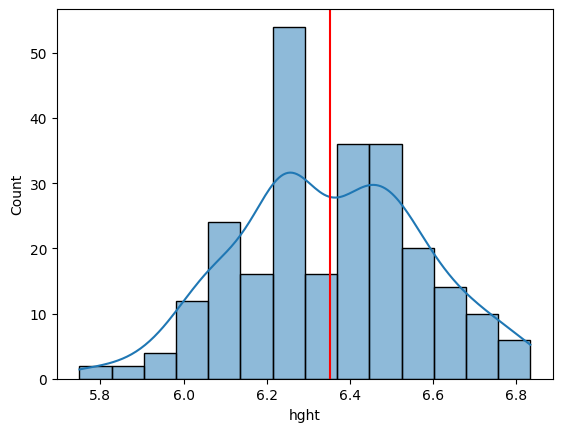

In [229]:
sns.histplot(data=all_p, x="hght", kde=True)
plt.axvline(x=all_p["hght"].mean(), color="red")

### 1.4 Feature Engineering & Continued Visualization

Below, I created a column "raw_arc" to measure the raw arc. While "plr" measures how high or low a player shoots respect to their height, raw arc measures simply the absolute angle value of each player. I used a Kinematics equation which takes player height, rim height, release time and release velocity into consideration to calculate the angle theta.

In [79]:
def calc_angle(y, d, y_0, v0) -> int:
    g=9.8
    a = (g * d**2) / (2 * v0**2)
    b = (g * d**2) / (2 * v0**2) - d
    c = y - y_0 + (g * d**2) / (2 * v0**2)
    discriminant = b**2 - 4 * a * c
    
    T1 = (-b + np.sqrt(discriminant)) / (2 * a)
    T2 = (-b - np.sqrt(discriminant)) / (2 * a)
    
    theta1 = np.arctan(T1)
    theta2 = np.arctan(T2)
    theta1_degrees = np.rad2deg(theta1)
    theta2_degrees = np.rad2deg(theta2)
    
    return theta2_degrees


all_p["raw_arc"] = all_p.apply(
    lambda x: calc_angle(10, x["spl"], x["hght"], x["rv"]), axis=1
)

C:\Users\kangj\AppData\Local\Temp\ipykernel_24788\4237928495.py:8: RuntimeWarning: invalid value encountered in sqrt
  T1 = (-b + np.sqrt(discriminant)) / (2 * a)
C:\Users\kangj\AppData\Local\Temp\ipykernel_24788\4237928495.py:9: RuntimeWarning: invalid value encountered in sqrt
  T2 = (-b - np.sqrt(discriminant)) / (2 * a)


In [80]:
all_p.describe()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,at1t,at1x,at1y,at1z,spl,pl,plr,raw_arc
count,252.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,253.000000,253.000000,253.000000,253.000000,261.000000,268.000000,261.000000,231.000000
mean,6.352511,0.142442,0.040309,3.135205,0.430797,-0.041056,-0.010369,8.333148,14.784885,-7.651967,0.011664,12.446915,0.314901,0.395927,0.022836,7.117650,5.262529,5.665287,1.107246,47.982317
std,0.225176,0.630462,0.513233,0.410319,0.057823,0.113808,0.075240,0.587508,2.590201,2.144440,1.173119,2.422471,0.056378,0.268415,0.181718,0.678157,0.691342,1.229214,0.085628,5.187586
min,5.749998,-1.384817,-2.194413,1.308812,0.272000,-0.733733,-0.605164,6.787648,8.559975,-16.950415,-7.727016,7.358225,0.046000,-0.500402,-0.832164,3.271465,3.030942,0.000000,1.019566,28.918328
25%,6.249998,-0.265232,-0.177503,2.886822,0.385000,-0.059360,-0.032188,7.920840,13.545274,-8.746281,-0.489005,11.201108,0.286000,0.259066,-0.049002,6.840375,4.823452,5.219478,1.066395,44.836017
50%,6.333331,0.058235,0.083595,3.108333,0.428000,-0.020806,-0.011425,8.389865,14.421921,-7.695426,0.082478,12.286630,0.314000,0.375142,0.015921,7.162936,5.256649,5.757430,1.089419,48.043270
75%,6.499997,0.462744,0.295127,3.324144,0.469000,0.005322,0.005379,8.712911,15.554446,-6.750653,0.562314,13.253243,0.343000,0.515295,0.084862,7.555631,5.664568,6.224100,1.116879,50.970166
max,6.833331,2.740010,1.831524,4.727747,0.598000,0.341767,0.480878,10.517372,29.970071,5.695147,5.123171,25.030400,0.522000,1.928642,1.380436,9.016217,7.946284,9.441792,1.877879,64.423941


Exploration of relative arc for made and missed shots. While ANOVA may be required to justify this, it is clear that even after considering the standard deviation, that made shots have much higher arc than missed shots. This means that generally, players sink in more shots when they shoot higher.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Shooting Guard and Point Guard'),
  Text(1, 0, 'Point Guard'),
  Text(2, 0, 'Small Forward and Shooting Guard'),
  Text(3, 0, 'Small Forward and Shooting Guard and Power Forward'),
  Text(4, 0, 'Shooting Guard'),
  Text(5, 0, 'Shooting Guard and Small Forward'),
  Text(6, 0, 'Point Guard and Shooting Guard'),
  Text(7, 0, 'Power Forward and Small Forward and Shooting Guard'),
  Text(8, 0, 'Shooting Guard and Small Forward and Power Forward'),
  Text(9, 0, 'Small Forward and Power Forward and Shooting Guard'),
  Text(10, 0, 'Power Forward and Shooting Guard'),
  Text(11, 0, 'Small Forward and Shooting Guard and Point Guard')])

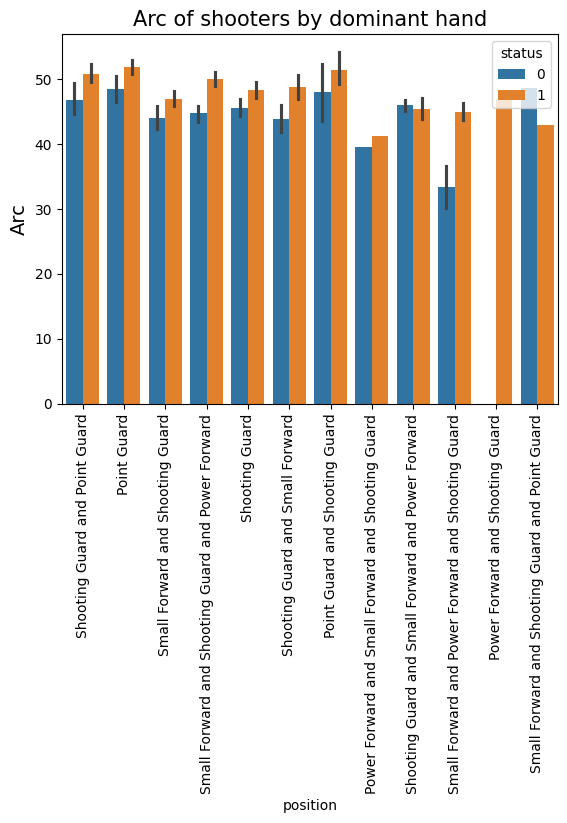

In [88]:
sns.barplot(data=all_p, x="position", y="raw_arc", hue="status")
plt.title("Arc of shooters by dominant hand", fontsize = 15)
plt.ylabel("Arc", fontsize = 14)
plt.xticks(rotation=90)

On the other hand, "rvz" -- upward release velocity is not necessarily higher (ANOVA required for accurate results). Shooting upward with more power is not necessarily significant to sinking the shot. This may be counter-intuitive to the arc portion above, however, recall  that one can generate more arc by having a proper or cleaner shot form.

Text(0, 0.5, 'Z velocity')

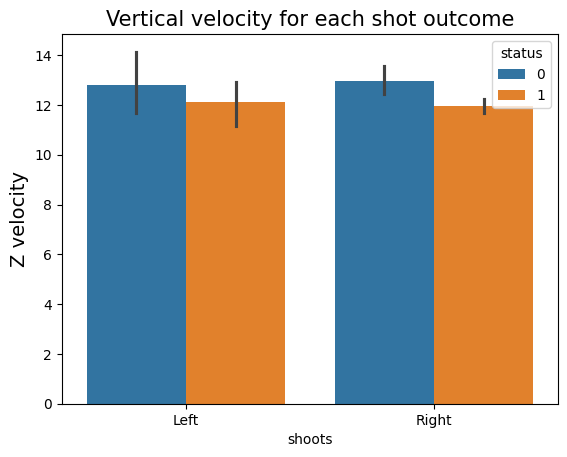

In [92]:
sns.barplot(data=all_p, x="shoots", y="rvz", hue="status")
plt.title("Vertical velocity for each shot outcome", fontsize = 15)
plt.ylabel("Z velocity", fontsize = 14)

We see that the convolution of the shot is linearly correlated with the how far thje ball is pulled down the ball before the shot. 

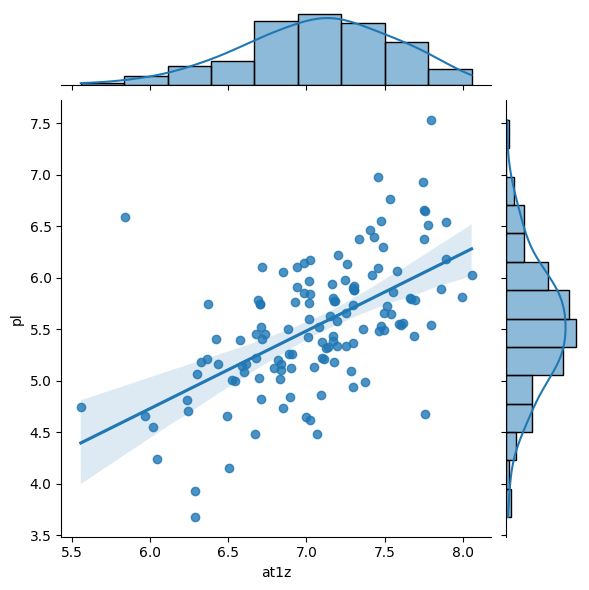

In [298]:
sns.jointplot(data=all_p[all_p["status"] == 1], x="at1z", y="pl", kind="reg")

### 1.5 Relationship of many different features

There are many interesting subtle relationships shown from scatterplots below. 

- rv vs raw_arc: Class 1 has generally higher arc and they stay consistent at around 12-15 release velocity, but Class 0 fluctuates at higher release velocity. 
- rz vs raw_arc:  Negative linear curve, showing that lower release point results in higher arc.
- at1y vs raw_arc: Higher arc shooters do NOT pull back the ball when shooting. 
- rx vs raw_arc: Higher arc shooters & made shots generally do NOT have any pocket.
- ry vs raw_arc: The amount you pull back does not fluctuate for Class 1.

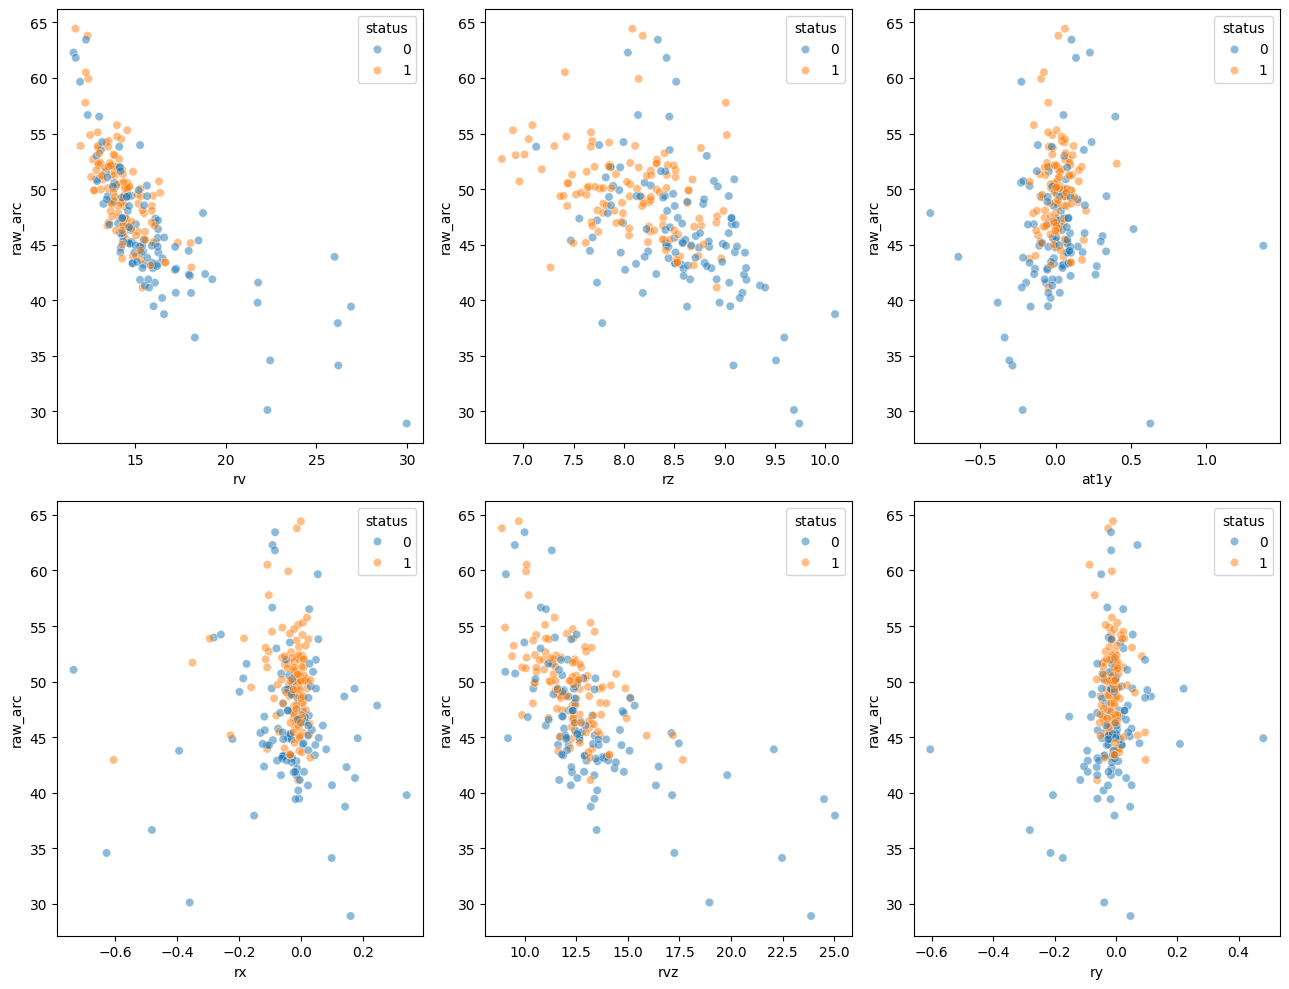

In [1041]:
fig, ax = plt.subplots(2, 3, figsize=(13, 10))
sns.scatterplot(data=all_p, x="rv", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 0])
sns.scatterplot(data=all_p, x="rz", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 1])
sns.scatterplot(data=all_p, x="rx", y="raw_arc", hue="status", alpha=0.5, ax=ax[1, 0])
sns.scatterplot(data=all_p, x="rvz", y="raw_arc", hue="status", alpha=0.5, ax=ax[1, 1])
sns.scatterplot(
    data=all_p, x="at1y", y="raw_arc", hue="status", alpha=0.5, ax=ax[0, 2]
)  # shot preparation
sns.scatterplot(data=all_p, x="ry", y="raw_arc", hue="status", alpha=0.5, ax=ax[1, 2])
fig.tight_layout()

The correlation matrix below of all metrics contain some beautiful insights.
- The release time (rt) seems to be quite positively correlated with straight line path (spl), ball path (pl) and relative arc (plr). This means that the more time you take to shoot (more prep.), the shot becomes further and more convoluted.
- Height (hght) and upward release coordinate (rz) has a strong negative correlation with raw arc. This actually tells us that the taller you are, the flatter the shot & the more upward your point of release is, the worse arc you have!
- However, relative arc is postively correlated with rz. This tells us that yes, the higher your shooting point is located, the more convoluted the shot gets, but lower arc. Stephen Curry pulls it up from his chest (high arc) but Kawhi Leonard has a very high release point (low arc).  

In [238]:
all_p.drop(columns=["name", "status", "position", "shoots", "college"]).corr()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,...,at1t,at1x,at1y,at1z,spl,pl,plr,fg,3fg,raw_arc
hght,1.000000,-0.173441,-0.028044,0.300513,-0.099934,-0.095149,0.025038,0.408280,0.038207,0.080392,...,-0.031112,-0.057009,0.005907,0.386153,0.163064,0.029727,-0.179367,0.182550,-0.033002,-0.460906
bx,-0.173441,1.000000,-0.071657,-0.165754,0.403071,0.048938,0.082552,0.164699,0.159374,-0.289629,...,0.158793,0.478464,0.141903,-0.203371,0.322545,0.332359,0.056292,0.043573,-0.074779,-0.153571
by,-0.028044,-0.071657,1.000000,0.088345,-0.118915,0.296436,0.213795,-0.088322,-0.268322,0.125224,...,-0.162035,-0.056758,0.528415,-0.037855,-0.152113,-0.197292,-0.054646,0.054572,0.020712,0.260965
bz,0.300513,-0.165754,0.088345,1.000000,-0.051223,0.071223,-0.083836,0.103135,0.008221,-0.072028,...,-0.313964,-0.082848,0.046081,-0.150928,-0.505124,-0.359867,0.279862,0.087114,0.162324,0.007667
rt,-0.099934,0.403071,-0.118915,-0.051223,1.000000,-0.114920,-0.109967,0.440299,0.017725,-0.352637,...,0.580008,0.269841,0.007686,0.017165,0.458318,0.693576,0.520973,0.055500,-0.131597,-0.104155
rx,-0.095149,0.048938,0.296436,0.071223,-0.114920,1.000000,-0.032298,-0.032388,0.073513,-0.282512,...,-0.330693,0.538503,-0.002211,-0.281826,-0.096319,-0.072815,0.055214,-0.018175,-0.035618,0.000370
ry,0.025038,0.082552,0.213795,-0.083836,-0.109967,-0.032298,1.000000,-0.021746,-0.277914,0.261389,...,0.082606,-0.028243,0.645687,0.155470,0.047056,-0.018340,-0.109866,-0.000097,0.001038,0.151672
rz,0.408280,0.164699,-0.088322,0.103135,0.440299,-0.032388,-0.021746,1.000000,0.072602,-0.437411,...,0.204547,0.386366,-0.004980,0.584873,0.793478,0.724236,-0.067171,0.041457,-0.065437,-0.493860
rv,0.038207,0.159374,-0.268322,0.008221,0.017725,0.073513,-0.277914,0.072602,1.000000,-0.445786,...,-0.108407,0.383742,-0.221282,-0.233900,0.080030,0.156474,0.122031,0.110608,0.018361,-0.734032
rvx,0.080392,-0.289629,0.125224,-0.072028,-0.352637,-0.282512,0.261389,-0.437411,-0.445786,1.000000,...,0.001414,-0.746641,0.186691,-0.006669,-0.338976,-0.385501,-0.100561,-0.051685,-0.038992,0.410575


### 1.6 Descriptive Statistics

Target values are even (50% each) which prevents class imbalance for classification tasks.

In [1043]:
all_p["status"].value_counts()

status
1    134
0    134
Name: count, dtype: int64

Class 0 has higher at1x, at1y and at1z which indicates that their shot is less "standard" as their shooting pocket is more on the right, pulled back more, and is further upwards (slightly).

In [1044]:
all_p.groupby(["status"])[["at1x", "at1y", "at1z"]].mean()

,at1x,at1y,at1z
status,,,
0,0.437831,0.027583,7.168459
1,0.356902,0.018416,7.070332


Below is the top 3 universities that output the most NBA players according to the data.

In [138]:
all_p["college"].value_counts().sort_values(ascending=False).head(3)

college
University of California, Los Angeles    12
University of North Carolina             10
University of Michigan                    8
Name: count, dtype: int64

Pivot table of release points of shooters. There is an obvious quantitative difference for all statistics with Class 0 generally having higher rz, a slightly leftward hand release poinnt and pulled back shot.

In [1045]:
# rx,rv,rz
metrics = ["max", "min", "mean", "std"]
pd.pivot_table(
    all_p,
    values=["rx", "ry", "rz"],
    index=["status"],
    aggfunc={"rx": metrics, "ry": metrics, "rz": metrics},
)

rx                                      ry                      \
             max      mean       min       std       max      mean       min   
status                                                                         
0       0.341767 -0.044415 -0.733733  0.142661  0.480878 -0.012021 -0.605164   
1       0.030926 -0.037874 -0.604554  0.077579  0.096927 -0.008803 -0.085424   

                         rz                                
             std        max      mean       min       std  
status                                                     
0       0.103254  10.517372  8.565169  7.128506  0.558280  
1       0.031007   9.137575  8.113247  6.787648  0.528546

The figure below shows the average field goal percentage for each position coming from corresponding colleges.

In [121]:
all_p[["fg", "3fg"]] = all_p[["fg", "3fg"]].astype("float64")
pd.crosstab(index=all_p["position"], columns=all_p["college"], values=all_p["fg"], aggfunc='mean', dropna=True)

college,Arizona State University,Boston College,Butler University,"California State University, Fresno",Cleveland State University,Creighton University,Davidson College,DePaul University,Duke University,Georgetown University,...,University of Texas at Austin,University of Washington,University of Wisconsin,Villanova University,Virginia Commonwealth University,Wake Forest University,Washington State University,Weber State University,Western Carolina University,Western Kentucky University
position,,,,,,,,,,,,,,,,,,,,,
Point Guard,NaN,42.9,NaN,NaN,40.7,NaN,47.7,NaN,46.5,NaN,...,41.3,NaN,NaN,42.4,47.2,45.7,NaN,43.4,NaN,NaN
Point Guard and Shooting Guard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.7,NaN,...,43.6,43.7,43.2,40.1,NaN,NaN,NaN,NaN,43.7,NaN
Power Forward and Small Forward and Shooting Guard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shooting Guard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.9,NaN,NaN,45.0
Shooting Guard and Point Guard,44.3,NaN,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,41.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shooting Guard and Small Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shooting Guard and Small Forward and Power Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Small Forward and Power Forward and Shooting Guard,NaN,46.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Small Forward and Shooting Guard,NaN,NaN,NaN,43.3,NaN,NaN,NaN,NaN,NaN,41.3,...,NaN,42.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, the figure demonstrates the number of players who use left and right as their dominant shooting hand. We see that there are drastically more right hand players.

In [113]:
pd.crosstab(index=all_p["position"], columns=all_p["shoots"], margins=True, margins_name="Total")

shoots,Left,Right,Total
position,,,
Point Guard,4,64,68
Point Guard and Shooting Guard,4,36,40
Power Forward and Shooting Guard,0,2,2
Power Forward and Small Forward and Shooting Guard,0,2,2
Shooting Guard,4,44,48
Shooting Guard and Point Guard,4,24,28
Shooting Guard and Small Forward,0,30,30
Shooting Guard and Small Forward and Power Forward,0,4,4
Small Forward and Power Forward and Shooting Guard,0,4,4


## 2. Preprocessing

Objectives:
1. Remove duplicated rows to decrease redundancy (in case any)
2. Split the data into training and testing sets
3. Build a pipeline to preprocess the data
4. Conduct hyperparameter search for dimensionality reduction via SelectKBest

In [1046]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
import joblib

# from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

### 2.1 Basic Preprocessing

Straight line path and relative arc columns were removed for future accuracy. Here is why:
- Straight line path does not provide any particular unique insights about a player since it is mostly similar, especially when we are taking into consideration a group of same positions.
- "plr" is not a good feature to depict "arc" -- another reason why "raw_arc" had to be engineered. This is because it measures the proportion between "spl" and "pl". However, imagine 2 players with the same arc but one is taller than the other. The "plr" for the taller player will be larger due to less "spl" from his height. Hence, it makes it seem like the taller player has more arc but they have identical arc.

In [1047]:
all_p.drop(columns=["spl", "plr", "position", "fg", "fg3", "shoots", "college"], inplace=True)

Remove duplicates as we don't want our predictions to be inaccurate due to bunch of copied values.

In [1048]:
all_p.drop_duplicates()

,hght,bx,by,bz,rt,rx,ry,rz,rv,rvx,rvy,rvz,at1t,at1x,at1y,at1z,pl,status,raw_arc
0,6.416664,-0.129515,0.159514,3.354385,0.378,0.007704,0.013134,8.180299,14.422596,-7.145353,-0.470512,12.519338,0.284,0.340173,0.074602,7.174992,5.186692,1,48.473144
1,6.416664,-0.022428,0.200926,3.322677,0.383,-0.020376,0.010732,8.535254,14.442496,-7.811150,-0.417388,12.140734,0.268,0.406480,0.054247,7.312969,5.569208,0,47.408170
2,6.166664,-0.192844,-0.158115,2.917786,0.371,0.015377,-0.005018,7.653078,14.671368,-6.933572,-0.053912,12.929490,0.292,0.276692,0.035454,6.794141,5.123032,1,50.241968
3,6.166664,0.160019,-0.333957,3.006314,0.392,0.026035,-0.042586,7.991336,16.117911,-9.120067,0.643254,13.273947,0.275,0.493335,-0.043557,6.733346,5.294511,0,46.947865
4,6.666664,0.279411,0.142605,3.189609,0.439,-0.108531,0.004955,8.556270,14.881033,-6.697380,0.330577,13.284614,0.320,0.289360,0.053704,7.013671,5.758962,1,43.944807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,6.249998,1.766881,-1.398022,1.991248,0.511,-0.733733,0.037351,7.819601,13.480980,-6.750653,0.202463,11.667241,NaN,NaN,NaN,NaN,6.747443,0,51.057250
364,6.583331,-0.586282,-0.012192,3.261287,0.387,-0.033434,-0.052607,8.499812,14.281961,-6.401334,0.953329,12.731398,0.305,0.228760,-0.128055,7.614102,5.558832,1,46.286464
365,6.583331,1.559400,0.988611,3.654317,0.519,0.142942,0.046699,10.096468,16.601861,-10.063614,-0.076595,13.203772,NaN,NaN,NaN,NaN,7.479449,0,38.751297
366,6.416664,-0.476678,0.131646,3.301677,0.389,-0.023809,-0.004602,8.266374,13.911234,-7.695426,-0.135239,11.588121,0.280,0.368932,0.124445,7.256036,5.339680,1,49.286087


### 2.2 Pipeline & Data Splitting

The pipeline includes:
- RobustScaler() to scale data like StandardScaler() but according to quantiles to make it robust.  
- KNNImputer() to fill any NA values with rows that are the most similar/closest. This is effective in classification tasks as we do not want to add some random values for our NA values that will make it inaccurate. 

In [1049]:
general_pipeline = Pipeline(
    [("scaler", RobustScaler()), ("imputer", KNNImputer(n_neighbors=3))]
)

-> Split data into features (X) and targets (y)

In [1050]:
X = all_p.drop(columns="status")
y = all_p["status"]

-> Implement the pipeline on the feature values

In [1051]:
X = general_pipeline.fit_transform(X)

-> Use train_test_split() function to take 2/3 of data as training set and 1/3 as testing set

In [1052]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

## 3. Feature Selection

Objectives: 
- For all models, find the "k" best features to classify made and missed shots. 
- Visualize the accuracy for each number of features
- Select the features with the highest accuracy but lowest number of features to prevent "curse of dimensionality".

### 3.1 Model Prep. & Exploring feature accuracy

-> Prepare all 4 models we will use

In [1053]:
# create list of all models we will use
models = [
    {"name": "LogisticRegression", "model": LogisticRegression()},
    {"name": "RandomForest", "model": RandomForestClassifier()},
    {"name": "SVM", "model": SVC()},
    {"name": "KNN", "model": KNeighborsClassifier()},
]

-> find_best_features(m) to loop through each models and all features to calculate the corresponding accuracy.

In [1054]:
def find_best_features(m) -> list:
    result = []
    for i in range(0, len(models)):
        for j in range(1, X.shape[1]):
            pipeline = Pipeline(
                [
                    ("preprocessing", general_pipeline),
                    ("feature_selection", SelectKBest(f_classif, k=j)),
                    ("model", m[i]["model"]),
                ]
            )
            pipeline.fit(X_train, y_train)
            score = pipeline.score(X_test, y_test)
            result.append({"name": m[i]["name"], "n_features": j, "score": score})
    return result


print(find_best_features(models))

[{'name': 'LogisticRegression', 'n_features': 1, 'score': 0.5842696629213483}, {'name': 'LogisticRegression', 'n_features': 2, 'score': 0.6179775280898876}, {'name': 'LogisticRegression', 'n_features': 3, 'score': 0.7191011235955056}, {'name': 'LogisticRegression', 'n_features': 4, 'score': 0.6741573033707865}, {'name': 'LogisticRegression', 'n_features': 5, 'score': 0.6404494382022472}, {'name': 'LogisticRegression', 'n_features': 6, 'score': 0.651685393258427}, {'name': 'LogisticRegression', 'n_features': 7, 'score': 0.6966292134831461}, {'name': 'LogisticRegression', 'n_features': 8, 'score': 0.7528089887640449}, {'name': 'LogisticRegression', 'n_features': 9, 'score': 0.7415730337078652}, {'name': 'LogisticRegression', 'n_features': 10, 'score': 0.7415730337078652}, {'name': 'LogisticRegression', 'n_features': 11, 'score': 0.7415730337078652}, {'name': 'LogisticRegression', 'n_features': 12, 'score': 0.7303370786516854}, {'name': 'LogisticRegression', 'n_features': 13, 'score': 0.7

### 3.2 Visualizing results

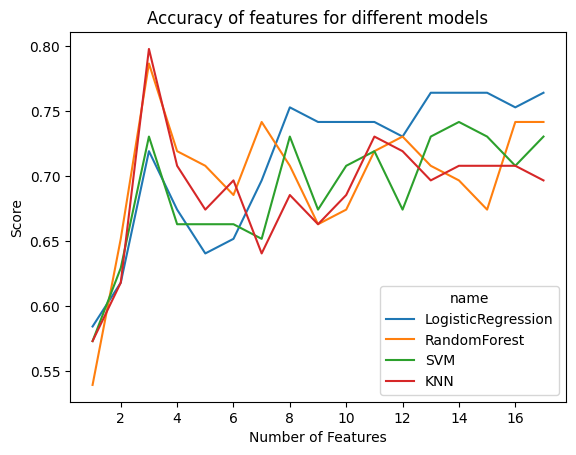

In [1055]:
graphdf = pd.DataFrame.from_dict(find_best_features(models))
sns.lineplot(data=graphdf, x="n_features", y="score", hue="name")
plt.title("Accuracy of features for different models")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.show()

While there are options to choose from, we will choose the number of features that is the lowest, yet yields one of the highest accuracy. Graphically, KNN and RandomForest seems to be the best here, and so we will create a script to execute our results in a clean form.

### 3.3 Final Summary 

For each model names, the lowest feature was selected through rank() and the scores were listed. KNN and RandomForest only requires 3 features out of 15 to yields highest accuracies of 0.79 and 0.76 respectively.

In [1056]:
# find optimal features for each models
graphdf["score_rank"] = graphdf.groupby("name")["score"].rank(ascending=False)


k_best = (
    graphdf[np.floor(graphdf["score_rank"]) <= 2][["name", "n_features", "score"]]
    .reset_index()
    .drop(columns="index")
)
k_best["feature_rank"] = k_best.groupby("name")["n_features"].rank()
k_best = k_best[k_best["feature_rank"] == 1]

k_best

,name,n_features,score,feature_rank
0,LogisticRegression,13,0.764045,1.0
4,RandomForest,3,0.786517,1.0
5,SVM,14,0.741573,1.0
6,KNN,3,0.797753,1.0


## 4. Hyperparmeter Search

Objectives:
- Create a parameter grid of all models with various hyperparameters
- Run the search with the number of features chosen for each models
- Evaluate the results

### 4.1 Parameter Grid

-> pg is an array that contains for dictionaries of the 4 estimators and bunch of hyperparams.

In [1057]:
pg = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "params": {
            "solver": [
                "lbfgs",
                "liblinear",
                "newton-cg",
                "newton-cholesky",
                "sag",
                "saga",
            ],
            "C": [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000],
        },
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(),
        "params": {
            "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
            "n_jobs": [5, 10, 15, 20, 25, -1],
        },
    },
    {
        "name": "SVM",
        "estimator": SVC(kernel="poly"),
        "params": {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "degree": [1, 2, 3, 4]},
    },
    {
        "name": "KNN",
        "estimator": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]},
    },
]

-> Inject optimal n_features into the dictionaries

In [1058]:
for i in range(0, len(k_best)):
    if pg[i]["name"] == k_best.iloc[i]["name"]:
        pg[i]["n_features"] = k_best.iloc[i]["n_features"]

In [1059]:
pg

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(),
  'params': {'solver': ['lbfgs',
    'liblinear',
    'newton-cg',
    'newton-cholesky',
    'sag',
    'saga'],
   'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000]},
  'n_features': 13},
 {'name': 'RandomForest',
  'estimator': RandomForestClassifier(),
  'params': {'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
   'n_jobs': [5, 10, 15, 20, 25, -1]},
  'n_features': 3},
 {'name': 'SVM',
  'estimator': SVC(kernel='poly'),
  'params': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
   'degree': [1, 2, 3, 4]},
  'n_features': 14},
 {'name': 'KNN',
  'estimator': KNeighborsClassifier(),
  'params': {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]},
  'n_features': 3}]

### 4.2 Using Grid-Search

-> GridSearchCV is one of the most popular methods for hyperparameter search. It essentially creates a "grid" of all combinations of hyperparameters to run cross-validation for all conditions. Then each results are stored. Here, a script is wrote to print the best estimators and parameters.

In [1060]:
gs_output = []
for i in range(0, 4):
    p = Pipeline(
        [
            ("feature_selection", SelectKBest(f_classif, k=pg[i]["n_features"])),
            ("model", pg[i]["estimator"]),
        ]
    )
    gs = GridSearchCV(cv=5, estimator=pg[i]["estimator"], param_grid=pg[i]["params"])
    gs.fit(X_train, y_train)
    gs_output.append(
        {
            "name": pg[i]["name"],
            "model": gs.best_estimator_,
            "best_param": gs.best_params_,
        }
    )
gs_output

c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\P

[{'name': 'LogisticRegression',
  'model': LogisticRegression(C=100),
  'best_param': {'C': 100, 'solver': 'lbfgs'}},
 {'name': 'RandomForest',
  'model': RandomForestClassifier(n_jobs=10),
  'best_param': {'n_estimators': 100, 'n_jobs': 10}},
 {'name': 'SVM',
  'model': SVC(C=1, degree=1, kernel='poly'),
  'best_param': {'C': 1, 'degree': 1}},
 {'name': 'KNN',
  'model': KNeighborsClassifier(n_neighbors=3),
  'best_param': {'n_neighbors': 3}}]

From this result, it is valid to conclude that these are the 4 best models based on features. Now it is left to choose the best models based on our evaluations.

## 5. Choosing the Best Model

Objective: Choose the best model based on the previous results.

### 5.1 Run CV

-> We will again inject the number of features we used to gs_output.

In [1061]:
# # RF seems better!
for i in range(0, len(gs_output)):
    gs_output[i]["n_features"] = k_best.iloc[i]["n_features"]
gs_output

[{'name': 'LogisticRegression',
  'model': LogisticRegression(C=100),
  'best_param': {'C': 100, 'solver': 'lbfgs'},
  'n_features': 13},
 {'name': 'RandomForest',
  'model': RandomForestClassifier(n_jobs=10),
  'best_param': {'n_estimators': 100, 'n_jobs': 10},
  'n_features': 3},
 {'name': 'SVM',
  'model': SVC(C=1, degree=1, kernel='poly'),
  'best_param': {'C': 1, 'degree': 1},
  'n_features': 14},
 {'name': 'KNN',
  'model': KNeighborsClassifier(n_neighbors=3),
  'best_param': {'n_neighbors': 3},
  'n_features': 3}]

-> Below script runs a final cross-validation of 10 folds to estimate the test error. Based on accuracy and the number of features we use, we can reason our way to get the best model for our prediction.

In [1062]:
for j in range(0, 4):
    cv_pipe = Pipeline(
        [
            ("feature_selection", SelectKBest(f_classif, k=gs_output[j]["n_features"])),
            ("model", gs_output[j]["model"]),
        ]
    )
    res = cross_validate(cv_pipe, X_train, y_train, scoring="accuracy", cv=10)
    print(f"{gs_output[j]['name']}: {np.mean(res['test_score'])}")

LogisticRegression: 0.7202614379084968
RandomForest: 0.6758169934640523
SVM: 0.6803921568627451
KNN: 0.6431372549019607


From this result, it is not necessarily the case that RandomForest and KNN (which we thought were the most ideal estimators) output the highest accuracy. However, it is up to us whether or not we will choose higher features (13 - Logistic Regression, 14 - SVC) for 4-5% more accuracy or substantially less features for 4-5% less accuracy. 
The simple conclusion is that in this project, we can brute force it and just test. However, in real scenario, we might not have access to test data. Hence, it is the most ideal to choose KNN or RandomForest as other models do not have drastically higher accuracy but has much higher feature count. This is BAD as dimension increases, it is likely that we are overfitting. This may yield bad results when we test on real new data.

### 5.2 Prediction

We can now create a pipeline to predict on new data. As a final result, it turns out that RandomForest with 500 trees returns a slightly higher result. Therefore, our final prediction will depend on that model. 

In [1069]:
final_pipe = Pipeline(
    [
        ("feature_selection", SelectKBest(f_classif, k=3)),
        ("model", RandomForestClassifier(n_estimators=100, n_jobs=10))
    ]
)

final_pipe.fit(X_train, y_train)
pred = final_pipe.predict(X_test)
conf_mat = confusion_matrix(y_test, pred)
print(accuracy_score(y_test, pred))

0.7528089887640449


In [1070]:
final_features = final_pipe.named_steps["feature_selection"].get_feature_names_out()
final_features

array(['x7', 'x8', 'x17'], dtype=object)

The final result yielded ~76% which is not a bad result at all. With 500 decision trees, the variance is completely surpressed and due to the low features, it actually performed better than the predicted testing error. Given that the class is split completely evenly, 76% seems to predict almost 4/5 of the time.
It is important that we check for class ratio to evaluate our accuracy though, because for example, 
1. If we have a 20:80 (Class 1 : Class 0), just predicting Class 0 yields 80% accuracy
2. If we have a 50:50, flipping a coin already yields 50% accuracy.

Overall, being much higher than a 50% accuracy (a coin-flip) is a good sign. However, there are rooms for improvements for higher accuracy which will be discused in the conclusion.

### 5.3 Confusion Matrix

Below is confusion matrix to visualize our predictions. It is good that the true positives and negatives are very high -- accurate predictions. We have a very high precision score but slightly lower recall score, which is something we may need to improve upon. But, whether or not we should just maintain the precision-recall tradeoff really depends on the application.

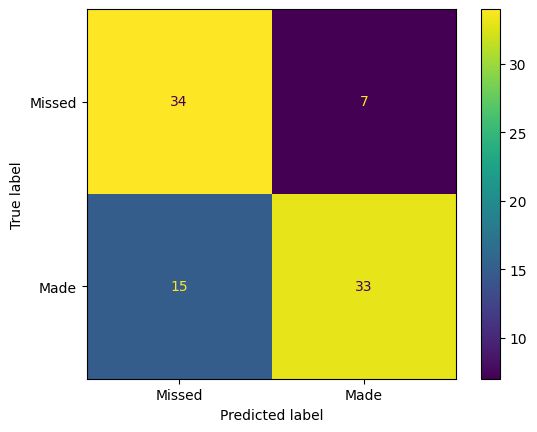

In [1071]:
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=["Missed", "Made"]
)
cm_display.plot()

This concludes our model evaluation with the following metrics:
- Yielded 76% Accuracy.
- Reduced dimension to 3 from 19.
- Recall score: 82.9%
- Precision score: 70.8%

## 6. Visualization

Finally, we can visualize our classification based on the 3 features. Since it is difficult to visualize our results on even 3-dimensional space, we can just look at one (the best) combination of features. This is the x8 and the x17 columns: rz and raw_arc respectively.

-> We will convert our predictions and test data into Pandas dataframe and join them to make our plotting easier. The labels for Class 1 is "Made" and Class 0 is "Miss".

In [1072]:
# make prediction on a new player test data
test = pd.DataFrame(X_test)
test

predictions = pd.DataFrame(pred, columns=["label"])
test.columns = ["x" + str(c) for c in test.columns]
labelled = pd.concat([test[final_features], predictions], axis=1)
labelled["label"] = ["Made" if i == 1 else "Miss" for i in labelled["label"]]
labelled

,x7,x8,x17,label
0,-0.340325,0.914640,-0.777145,Miss
1,1.214179,0.557154,-1.094978,Miss
2,-1.203891,0.751693,0.072630,Made
3,-0.970255,1.466091,-0.468017,Miss
4,0.518014,0.763607,-0.761461,Miss
...,...,...,...,...
84,0.548164,0.890529,-0.810155,Miss
85,0.504793,-0.063551,-0.494386,Miss
86,-0.823273,0.493127,0.007619,Made
87,0.155704,-0.192087,0.466317,Miss


### 6.1 Z-coordinate Release Point vs Raw Arc Scatterplot

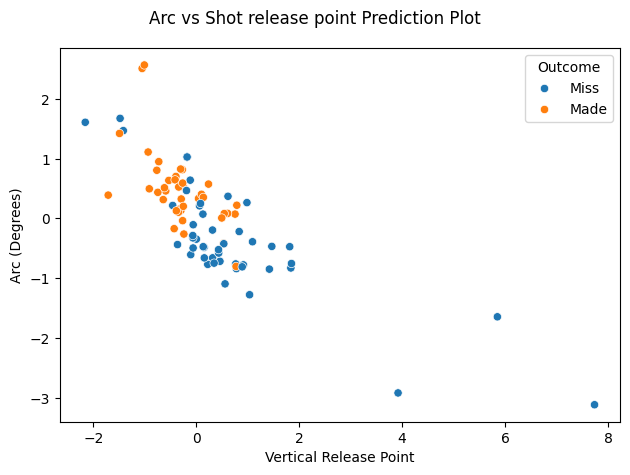

In [1078]:
sns.scatterplot(data=labelled, x="x8", y="x17", hue="label")
plt.xlabel("Vertical Release Point")
plt.ylabel("Arc (Degrees)")
plt.suptitle("Arc vs Shot release point Prediction Plot")
plt.legend(title="Outcome")
plt.tight_layout()

<h4> Summary: </h4>

In summary, the shots that players "make" reach a substantially higher arc point and have higher average arc. It is valid to assume now that players who shoot with higher arc are more likely to sink in the shot. This is scientifically true and (may be) proven as shooting the ball higher allows the ball to have more rim-margin (space) to travel into, whereas a flat shot will have less space as it travels towards the rim at a lower angle. 
We see another signficant insight in the plot which is the negative linear relationship between the arc and vertical release point (in player's perspective) of the shot. Generally, as release point increases vertically, the arc becomes lower. In other words, if you place the ball high above your head when you shoot, you have less arc and vice versa. This is also somewhat convincing looking at players like Kawhi who releases the ball at the top of his head has a very low arc shot, but Stephen Curry, who releases the ball in front of his head has a high arc shot.
It is concluded from our model that players who miss the shot tend to release the ball too high and shoot with low arc, which is seen from the abundnance of blue points at higher "rz". 

### 6.2 Model Persistence

We will lastly save our models and pipelines into files so that other users or viewers can try them out without complex code. Here, we used the joblib library to save our work which can be easily accessed after cloning this report on Github.

In [1068]:
joblib.dump(general_pipeline, "preprocess.joblib")
joblib.dump(final_pipe, "model.joblib")

['model.joblib']

## Conclusion

### Results & Real-Life connection

<strong> General Results  </strong>

Let's start by listing off the clear main differences between a swish and a brick according to the most important features as well as the summary provided by the EDA.
1. Arc: Made shots have higher arc point.
2. Release: Made shots generally have lower release point (at1z, rz).
3. Shoot pocket: Made shots have almost no shooting pocket, which is seen by the lack of fluctuations in the scatter plot of "rx vs raw_arc".
4. Pull back: Some players pull back the ball behind or to the top of their head when they shoot. This is almost not seen in shots that are made.

From correlation matrix, we saw:
1. Release time: More release time leads to longer straight line path & higher convolution. So, slower shots tend to go longer and higher.
2. Height is negatively correlated with arc -- taller players have less arc.

There were some surprising results, which were:
1. Made shots have lower vertical release velocity. We expect shooting stronger upwards leads to higher arc, but turns out it could be more about having a cleaner form and using more knees.
2. Arc is negatively correlated with convolution. This is a very surprising result that may or may not be a coincidence.

<strong> ML Results </strong>

From the 19 possible features and 4 different models with their own pros & cons, through dimensionality reduction and hyperparameter search, we were able to reduce down our final prediction with 3 features and 2 best models with ~76% accuracy.

By picking the model with highest accuracy but lowest feature, we were able to reduce the cross-validation and grid-search time process by 1.5 minutes.

K-Nearest Neighbors and RandomForest with 3 features yielded ~80% and ~79% accuracy respectively. 

By running grid search with parameters like C (penalty), n_neighbors, n_estimators (bagging) for corresponding models and using pipelines, we drastically reduced the fitting time and found optimal parameters more quickly.

By using grid-search, the model accuracy improved by 10% and with 3 features, we were able to achieve a 11% improvement in our testing accuracy due to preventing overfitting from the curse of dimensionality.

Lastly, we got 83% recall score with 71% precision score which are very high considering a even split of classes. Graphically, we could see a vivid classification where made shots had higher arc and lower vertical release point.

### What makes a great shooter?
Well, now we must answer the question of what creates a great shooter?
An ideal shooter derived from this report is:
- A shorter-end guard (to increase arc)
- High arc
- Clean form with less flick strength
- Straight angle release (no pocket)
- Low release point (chest area / in front of head)

Generally, the most important differences in a shot that goes in though, is the arc & the release point!

### Improvements
76% could be a reasonable yield, however, there are obvious improvements that can be made.

1. More Data

This report handles 268 rows, which is enough, but by adding approximately equal amounts of data to each classes may narrow down the characteristics of each classes. I personally felt that in many plots, the difference wasn't clear. It may be because all the metrics "quantitatively underestimated" (meaning that for example, a 0.05 inch difference in "rx" is a lot) or because the difference is actually subtle.

2. Further research/analysis

Throughout this report, I always wished that there were even more metrics included in this data. Given that I had to engineer a more accurate version of angle, it means that there were abundant and useful information that could allow me to engineer it but also lack of creative data involved. I want to explore things like "the amount of spin in the ball during the shot" or "how much knee players bend when they shoot". 
It is clear that the given data made a clear division between the classes, however, there is a possibility of more discoveries if there can be more measurements conducted. 

3. Different Methods

In terms of the code, the hyperparameter search process could be improved by trying out other efficient methods like RandomizedCV, Bayesian Optimization or Hyperband. Some of these methods may definitely increase either accuracy or speed as GridSearch is a great, thorough method but a brute-force one.

4. Other useful models

Ofcourse, other Scikit-Learn methods like Naive Bayes could be explored. There are lots of possibilities to increase accuracy, but these always have limits when the data is not sufficient.

### Future Questions

1. Exploring new components: How does the level of knee bent / hip angle / head tilt affect the shot outcome? 

2. Trying a regression: How is the average goal affected by one's shooting habits?

3. A new idea: Can we predict the height of the defender based on shot metrics? 

## References

- https://news.ku.edu/news/article/2022/05/26/study-photographically-identifies-characteristics-make-proficient-basketball-scorers (Source: KU News, Author: Mike Krings,"Characteristics that make a good shooter")
- https://www.inpredictable.com/2021/01/nba-player-shooting-motions-data-dump.html (SourceL inpredictable, SportVU Data)
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9590067/ (Source: NIH, Authors: Dimitrije Cabarkapa,* Damjana V. Cabarkapa, Nicolas M. Philipp, Drake A. Eserhaut, Gabriel G. Downey, and Andrew C. Fry, "Impact of Distance and Proficiency on Shooting Kinematics in Professional Male Basketball Players")
- https://scholarworks.umt.edu/cgi/viewcontent.cgi?article=6850&context=etd (Source: Research paper from University of Montana, Author: Robert Dale Ballinger, "Study of basketball field goal shooting deviations for selected male college students at Montana State University 1961-62")
- https://www.btsbioengineering.com/wp-content/uploads/2023/05/Struzik-et-al-2014.pdf (Source: De Gruyter, Authors: Artur Struzik, Bogdan Pietraszewski, Jerzy Zawadzki, Biomechanical Analysis of a Basketball shot)